[<img src="https://www.arcosdorados.com/wp-content/uploads/2019/05/ArcosDoradosLogoX.png" width="300" height="150" align='right'>](http://digitalhouse.com.ar/)


Se realizo el analisis siguiendo los siguientes articulos: [towards](https://towardsdatascience.com/rfm-segmentation-using-quartiles-and-jenks-natural-breaks-924f4d8baee1)

[paper](https://www.sciencedirect.com/science/article/pii/S1319157818304178)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importo el dataset provisto relacinado con compras en amazon.
df = pd.read_csv('amazon_reviews_us_Luggage_v1_00.tsv',sep='\t',error_bad_lines=False,parse_dates=True)

b'Skipping line 21775: expected 15 fields, saw 22\nSkipping line 35823: expected 15 fields, saw 22\nSkipping line 46386: expected 15 fields, saw 22\n'
b'Skipping line 75998: expected 15 fields, saw 22\nSkipping line 82507: expected 15 fields, saw 22\nSkipping line 98223: expected 15 fields, saw 22\nSkipping line 129152: expected 15 fields, saw 22\nSkipping line 130115: expected 15 fields, saw 22\n'
b'Skipping line 131270: expected 15 fields, saw 22\nSkipping line 151687: expected 15 fields, saw 22\n'
b'Skipping line 196882: expected 15 fields, saw 22\nSkipping line 213341: expected 15 fields, saw 22\nSkipping line 233947: expected 15 fields, saw 22\n'


In [3]:
df.dtypes

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object

In [4]:
# Parseo en formato fecha.
df['review_date']=pd.to_datetime(df.review_date)

In [5]:
df.review_date.max(),df.review_date.min(),df.review_date.max()-df.review_date.min()

(Timestamp('2015-08-31 00:00:00'),
 Timestamp('2002-11-05 00:00:00'),
 Timedelta('4682 days 00:00:00'))

Data desde 2002 hasta el 2015 (12 años) donde defino como el dia del estudio el dia 2015-09-01 como dia que se hizo el estudio.

Defino ademas que los clientes serian los revierws, la frequency y recency la tengo mientras que money vendrian a ser helpful_votes.
Seria interesante determinar el periodo de tiempo donde analizo. Para obtener la frecuencia estudiada.

In [6]:
import datetime as dt
anchorDate = dt.datetime(2015,9,1)
gbc = df.groupby('customer_id').agg({'review_date': lambda x: (anchorDate - x.min()).days,
                                     'product_id': lambda x: len(x)})
  

In [7]:
gbc.columns = ['tiempo_intereseña', 'Frequency']


In [8]:
gbc[gbc.Frequency>1]['tiempo_intereseña'].quantile(0.95),gbc[gbc.Frequency>1]['tiempo_intereseña'].quantile(0.95)/365

(1626.0, 4.454794520547945)

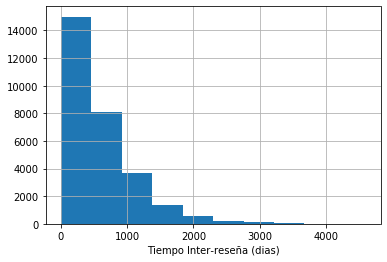

In [9]:
gbc[gbc.Frequency>1]['tiempo_intereseña'].hist()
plt.xlabel('Tiempo Inter-reseña (dias)')
plt.savefig('images/tiempo_interesania.png')

### Calculo del RFM dentro de los limites de fechas ( 3 años).

In [10]:
# Agrego el tiempo entre la reseña y la fecha del estudio.
df['tiempo_dias_reseña'] = df.review_date.apply(lambda x: abs((anchorDate-x).days))

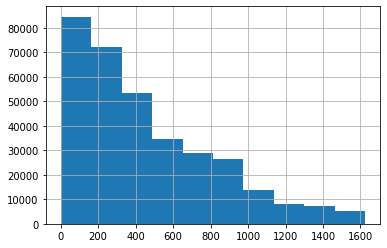

In [11]:
# filtro los reviews mas viejos de 945 dias.
df[df['tiempo_dias_reseña']<1626]['tiempo_dias_reseña'].hist()

In [12]:
df=df[df['tiempo_dias_reseña']<1626]

In [13]:

anchorDate = dt.datetime(2015,9,1)
rfm = df.groupby('customer_id').agg({'review_date': lambda x: (anchorDate - x.max()).days,
                                     'product_id': lambda x: len(x),
                                     'helpful_votes': lambda x: x.sum(),
                                      'star_rating': lambda x: x.mean()})
rfm.columns = ['Recency', 'Frequency', 'helpful_votes','star_rating']
print(df.shape,rfm.shape)

(334336, 16) (295631, 4)


In [14]:
334336/340000

0.9833411764705883

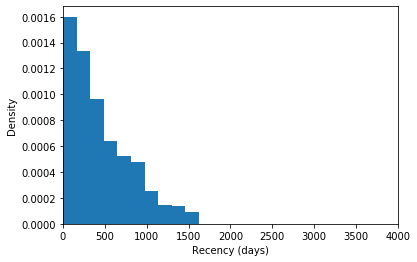

In [15]:

fig, ax = plt.subplots()
plt.savefig('images/Recency_distribution.png')
ax=rfm.Recency.hist(density=True,grid=False)
plt.xlim(0,4000)
plt.xlabel('Recency (days)')
plt.ylabel('Density');

In [16]:
df.total_votes - df.helpful_votes

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
334333    3.0
334334    0.0
334335    2.0
334336    0.0
334337    7.0
Length: 334336, dtype: float64

In [17]:
rfm.describe()

,Recency,Frequency,helpful_votes,star_rating
count,295631.000000,295631.000000,295631.000000,295631.000000
mean,447.786436,1.130923,2.105341,4.210581
std,369.699710,0.533661,13.439525,1.220519
min,1.000000,1.000000,0.000000,1.000000
25%,156.000000,1.000000,0.000000,4.000000
50%,346.000000,1.000000,0.000000,5.000000
75%,678.000000,1.000000,1.000000,5.000000
max,1625.000000,63.000000,1992.000000,5.000000


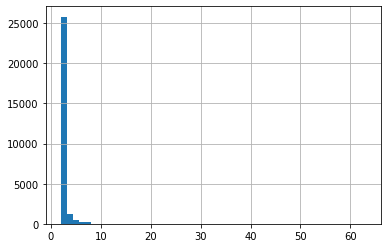

In [18]:
rfm[rfm.Frequency>1].Frequency.hist(bins=50)

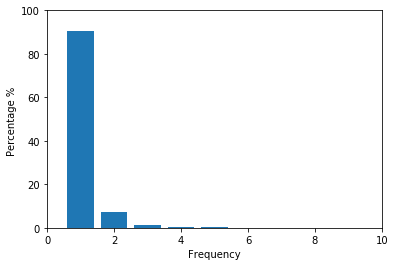

In [19]:
f=(rfm.Frequency.value_counts(normalize=True)*100).reset_index()
f.columns=['frequency','counts']
fig, ax = plt.subplots()
plt.savefig('images/Frequency_distribution.png')
f_plot = ax.bar(f.frequency,f.counts);
plt.xlim(0,10)
plt.ylim(0,100)
plt.xlabel('Frequency')
plt.ylabel('Percentage % ');

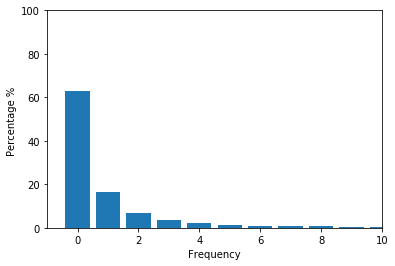

In [20]:
f=(rfm.helpful_votes.value_counts(normalize=True)*100).reset_index()
f.columns=['frequency','counts']
fig, ax = plt.subplots()
plt.savefig('images/helpful_votes_distribution.png')
f_plot = ax.bar(f.frequency,f.counts);
plt.xlim(-1,10)
plt.ylim(0,100)
plt.xlabel('Frequency')
plt.ylabel('Percentage % ');

### RFM clasico usando numero de votos positivos.

In [48]:
rfm1 = rfm[['Recency', 'Frequency', 'helpful_votes']]
rfm1.columns= ['Recency', 'Frequency', 'Monetary']

In [49]:
rfm1['r_score'] = pd.qcut(rfm1['Recency'], 2, labels=range(2,0,-1))
rfm1['f_score'] = rfm1['Frequency'].apply(lambda x: 1 if  x>1 else 2)
rfm1['m_score'] = rfm1['Monetary'].apply(lambda x: 1 if  x>=1 else 2)

In [50]:
rfm1.f_score.value_counts(normalize=True)*100

2    90.553088
1     9.446912
Name: f_score, dtype: float64

In [51]:
rfm1.m_score.value_counts(normalize=True)*100

2    62.878386
1    37.121614
Name: m_score, dtype: float64

In [52]:
df['helpful_ratio']= (df.helpful_votes / df.total_votes)*100
df['helpful_ratio'].fillna(-1,inplace=True)

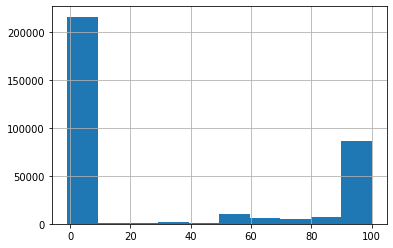

In [53]:
df.helpful_ratio.hist()

Conclusiones: En principio debería tener segmentos equipoblados y el binning no se puede hacer debido a que gran parte de la poblacion esta centrada en cero el valor Monerario (helpful_votes).
Amazon utiliza una estrategia donde tenes el salon de la fama de Reviews donde saca el sesgo de reviews pagas o subsidiadas y asi de esa manera identifica a aquellos reviewrs que son muy buenos y que solo quieren el reconocimiento intelectual y no el monetario.

In [54]:
rfm1['rfm_score'] = rfm1['r_score'].astype(str) + rfm1['f_score'].astype(str) + rfm1['m_score'].astype(str)

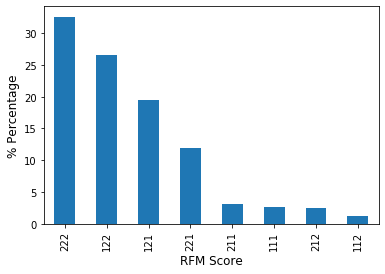

In [56]:
rfm1_bar = rfm1['rfm_score'].value_counts(normalize=True)*100 
ax = rfm1_bar.plot(kind='bar')
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("% Percentage", fontsize=12)
plt.savefig('images/rfm1.png')
plt.show()

### RFM clasico usando numero de votos positivos y estrellas promedio.

In [57]:
rfm2 = rfm[['star_rating', 'Frequency', 'helpful_votes']]
rfm2.columns= ['Recency', 'Frequency', 'Monetary']

In [58]:
rfm2['r_score'] = rfm2['Recency'].apply(lambda x: 1 if  x>2.5 else 2)
rfm2['f_score'] = rfm2['Frequency'].apply(lambda x: 1 if  x>1 else 2)
rfm2['m_score'] = rfm2['Monetary'].apply(lambda x: 1 if  x>=1 else 2)

In [59]:
rfm2['rfm_score'] = rfm2['r_score'].astype(str) + rfm2['f_score'].astype(str) + rfm2['m_score'].astype(str)

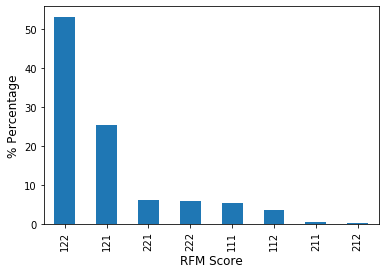

In [61]:
rfm2_bar = rfm2['rfm_score'].value_counts(normalize=True)*100 
ax = rfm2_bar.plot(kind='bar')
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("% Percentage", fontsize=12)
plt.savefig('images/rfm2.png')
plt.show()

# Clustering con HDBSCAN.

In [81]:
# Genero las dummies.
dummies = pd.get_dummies(df[['vine','verified_purchase']],drop_first=True)

In [83]:
df=pd.concat([df,dummies],axis=1)

In [84]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'tiempo_dias_reseña',
       'helpful_ratio', 'vine_Y', 'verified_purchase_Y'],
      dtype='object')

In [85]:
df_clustering = df.groupby('customer_id').agg({'review_date': lambda x: (anchorDate - x.max()).days,
                                     'product_id': lambda x: len(x),
                                     'helpful_votes': lambda x: x.sum(),
                                     'total_votes': lambda x: x.sum(),
                                     'star_rating': lambda x: x.mean(),
                                     'vine_Y': lambda x: x.sum(),
                                     'verified_purchase_Y': lambda x: x.sum()
                                              })

In [86]:
df_clustering.columns = ['Recency', 'Frequency','helpful_votes','total_votes','star_rating_avg','vine_Y','verified_purchase_Y']

In [88]:
df_clustering.describe()

,Recency,Frequency,helpful_votes,total_votes,star_rating_avg,vine_Y,verified_purchase_Y
count,295631.000000,295631.000000,295631.000000,295631.000000,295631.000000,295631.000000,295631.000000
mean,447.786436,1.130923,2.105341,2.499271,4.210581,0.003058,1.019927
std,369.699710,0.533661,13.439525,14.254023,1.220519,0.067956,0.538035
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,156.000000,1.000000,0.000000,0.000000,4.000000,0.000000,1.000000
50%,346.000000,1.000000,0.000000,0.000000,5.000000,0.000000,1.000000
75%,678.000000,1.000000,1.000000,2.000000,5.000000,0.000000,1.000000
max,1625.000000,63.000000,1992.000000,2030.000000,5.000000,7.000000,17.000000


In [89]:
df_clustering.shape

(295631, 7)

In [91]:
df_clustering.shape[0]*0.05

14781.550000000001

In [93]:
pip install hdbscan

     |████████████████████████████████| 4.7MB 1.3MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Stored in directory: /home/elias/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [96]:
# Normalizo el Dataset
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
df_clustering_norm = sc.fit_transform(df_clustering)
df_clustering_norm = pd.DataFrame(df_clustering_norm,columns=df_clustering.columns)

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=15000,min_samples=None, metric='euclidean')
clusterer.fit(df_clustering_norm)


In [ ]:
df_clustering['Cluster'] = pd.Series(clusterer.labels_, index=df_clustering.index)
df_clustering.head(3)

In [ ]:
clustering_results = (df_clustering.Cluster.value_counts(normalize=True)*100).reset_index()
clustering_results.columns = ['Cluster','% Percentage']

In [ ]:
clustering_results